# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***

The purpose of this project is to find lane lines on the road from still images and video streams.

First, a lane detection on a sample of still image is addressed.

Second, a lane detection on a collection of images is tested and outputs is to be saved as part of this exercise.

Thrid, a lane detection on video streams is tested and I will look for any improvements to be made as part of this problem solving section.

---
The optional challenge problem is atttempted to address issues associated with curved lanes.


---

## Set up packages to use

Prior to this problem solving, I will import all required packages for a lane detection for still images.

In [1]:
#import libraries to be used and set up for a plot inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

## Helper functions step by step

The lane detection problem solving is undertaken by the following order:
    

In [2]:
def detect_edges(img):
    #1. to gray colour
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    #2. experiment a kernel size and image smooothing through Gaussian Blur to remove noise
    #https://docs.opencv.org/3.1.0/d4/d13/tutorial_py_filtering.html
    #if sigmaX is non-positive, it is calculated from a kelnel size: sigma = 0.3\*((kernel_size-1)\*0.5 - 1) + 0.8
    kernel_size = 5
    gblur_img = cv2.GaussianBlur(gray_img,(kernel_size, kernel_size), sigmaX=0)
    
    #3. experiment various thresholds (min and max) to get sound canny edges
    min_threshold = 50
    max_threshold = 150
    canny_edges = cv2.Canny(gblur_img, min_threshold, max_threshold)
    
    return canny_edges

In [32]:
def confine_roi(img, edges):
    #1. create two mask background from the size of an image and make all pixels black (i.e. rgb 0)
    mask_background = np.zeros_like(edges)
    
    #2. get the size of an image and define vertices of region of interest - ellipse2Poly()
    img_shape = img.shape
    margin = 170
    vertices = np.array([[(margin,img_shape[0]),(img_shape[1]//2, img_shape[0]//2), (img_shape[1]-margin,img_shape[0])]], dtype=np.int32)
    
    #3. areas that are not masked (i.e. region of interest) are coloured white (255)
    #where there are more than 1 channel (e.g. RGB)
    if len(img_shape) > 2:
        channel_count = img_shape[2]
        not_mask_color = (255,) * channel_count
    else:
        not_mask_color = 255
        
    
    #4. cv2.fillPoly() fills an area bounded by several polygonal outlines with 1
    cv2.fillPoly(mask_background, vertices, not_mask_color)
    
    #5. bitwise_and finds an area where both pixel values are 1
    masked_edges = cv2.bitwise_and(edges, mask_background)
    
    return masked_edges

In [4]:
def connect_edges(edges):
    #1. define parameters for hough transform: rho, theta
    #distance
    rho = 2
    #angle
    theta = np.pi/180
    #minimum number of votes
    threshold = 50
    #minimum number of pixels making up a line
    min_line_length = 100
    #maximum gap in pixels between connectable line segments
    max_line_gap = 50
    
    #2. connect dots and edges through hough line transform
    hough_lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
    
    return hough_lines

In [5]:
def extrapolate_lines(img, lines):
    #1. initialise empty arrays for left lane and right lane Xs and Ys
    left_lanes = []
    right_lanes = []
    
    #2. for all lines found by hough transformation, get slopes and intercepts
    for line in lines:
        x1, y1, x2, y2 = np.squeeze(line)
        #fit each line between two points (i.e. x1, y1 and x2, y2)
        p_slope, p_int = np.polyfit((x1, x2), (y1, y2), 1)

        #if the slope is forward slash, then takes it into left; otherwise right
        if p_slope > 0:
            left_lanes.append((p_slope, p_int))
        else:
            right_lanes.append((p_slope, p_int))
        
    #3. get median of collections of slopes and intercepts to determine a single representative lane for each
    left_lanes_median = np.median(left_lanes, axis=0)
    right_lanes_median = np.median(right_lanes, axis=0)

    return [left_lanes_median, right_lanes_median]

In [6]:
def get_xys(img_shape, lanes):
    left_lanes = lanes[0]
    right_lanes = lanes[1]
    first_slope, first_int = left_lanes
    second_slope, second_int = right_lanes
    
    #3. get left lane xys through first slope and intercept
    margin = 200
    left_y1 = img_shape[0]
    left_y2 = int(left_y1 - margin)
    left_x1 = int((left_y1 - first_int)/first_slope)
    left_x2 = int((left_y2 - first_int)/first_slope)
    
    #4. get left lane xys through second slope and intercept
    right_y1 = img_shape[0]
    right_y2 = int(right_y1 - margin)
    right_x1 = int((right_y1 - second_int)/second_slope)
    right_x2 = int((right_y2 - second_int)/second_slope)
    
    return [[left_x1, left_y1, left_x2, left_y2], [right_x1, right_y1, right_x2, right_y2]]

In [7]:
def connect_lines(img, left_right_xys):
    #copy an image with zero initiations to draw lines on
    image_with_lines = np.zeros_like(img)
    #going through each xys and draw a line between them for left and right lanes
    if left_right_xys is not None:
        for i in range(len(left_right_xys)):
            x1, y1, x2, y2 = left_right_xys[i]
            cv2.line(image_with_lines, (x1, y1), (x2, y2), (178, 0, 255), 5)
    return image_with_lines

Wrapper function for all steps

In [8]:
def find_lanes(path2image):
    #reading in an image with cv2 instead of mpimg
    image = cv2.imread(path2image)

    #need to change BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
       
    detected_edges = detect_edges(image)
    masked_edges = confine_roi(image, detected_edges)
    hough_lines = connect_edges(masked_edges)
    median_lanes = extrapolate_lines(image, hough_lines)
    xys = get_xys(image.shape, median_lanes)
    connected_lines = connect_lines(image, xys)
    #addWeighted src1, src1 weight, src2, src2 weight, bias
    output_lines = cv2.addWeighted(image, 0.95, connected_lines, 5., 0.)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    fig.tight_layout()

    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=40)

    ax2.imshow(output_lines)
    ax2.set_title('Sample Result', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

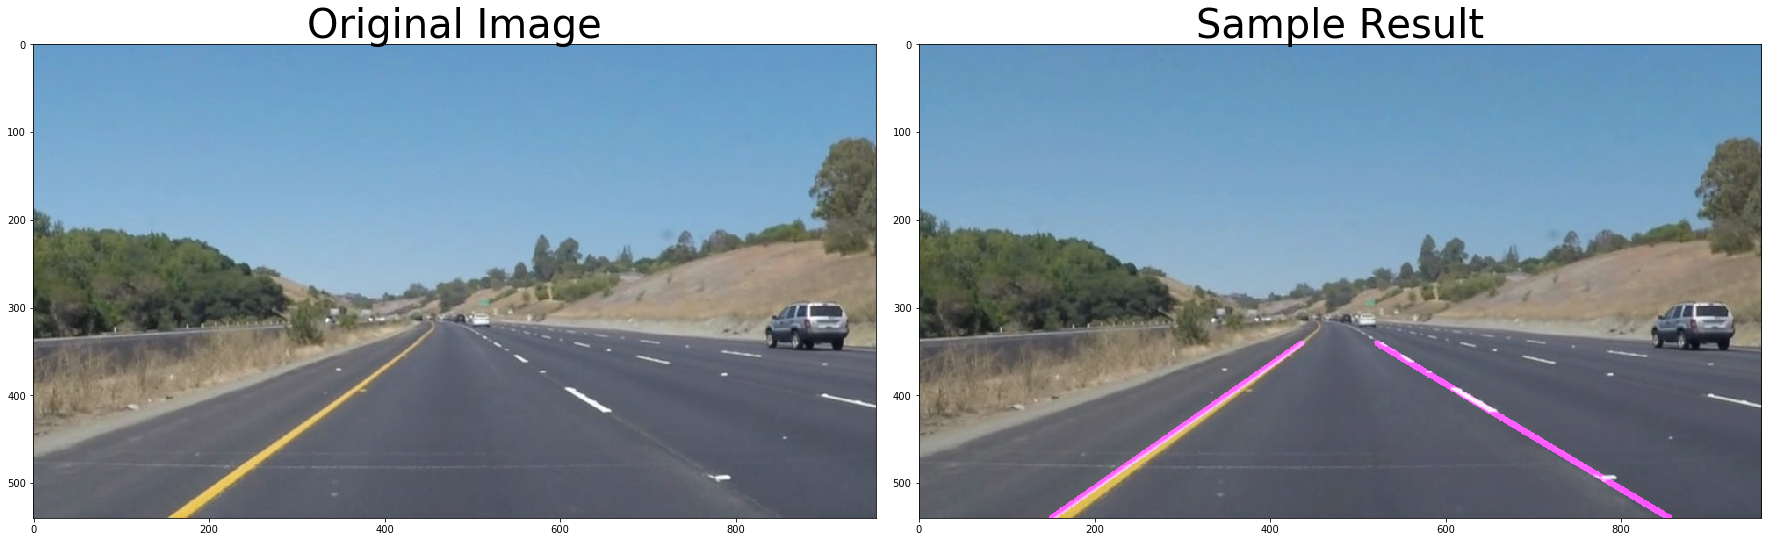

In [9]:
find_lanes('test_images/solidYellowCurve.jpg')

The lines seems to be reasonable on a sample image. Now I am ready to try on test images.

## Build a Lane Finding Pipeline for still images

To test on a collection of still images in a test directory and save the result, I am creating a helper function to save the resulting images.

In [74]:
def save_result(output_image, img):
#     if os.path.isdir('test_images_output'):
#         os.path.mkdir('test_images_output')
#     path_to_save = os.path.join('test_images_output/', img)
    cv2.imwrite(img, output_image)

In [76]:
def find_lanes_on_test(testdir):
    for img in os.listdir(testdir):
        #reading in an image with cv2 instead of mpimg
        image = cv2.imread(os.path.join(testdir, img))

        #need to change BGR to RGB because of cv2.imread()
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        detected_edges = detect_edges(image)
        masked_edges = confine_roi(image, detected_edges)
        hough_lines = connect_edges(masked_edges)
        median_lanes = extrapolate_lines(image, hough_lines)
        xys = get_xys(image.shape, median_lanes)
        connected_lines = connect_lines(image, xys)
        #addWeighted src1, src1 weight, src2, src2 weight, bias
        output_lines = cv2.addWeighted(image, 0.95, connected_lines, 5., 0.)
        
        #change colour BGR to RGB because of cv2
        output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
        
        #save the result from the image
        save_result(output_lines, img)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        fig.tight_layout()

        ax1.imshow(image)
        ax1.set_title('Original Image', fontsize=40)

        ax2.imshow(output_lines)
        ax2.set_title('Sample Result', fontsize=40)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

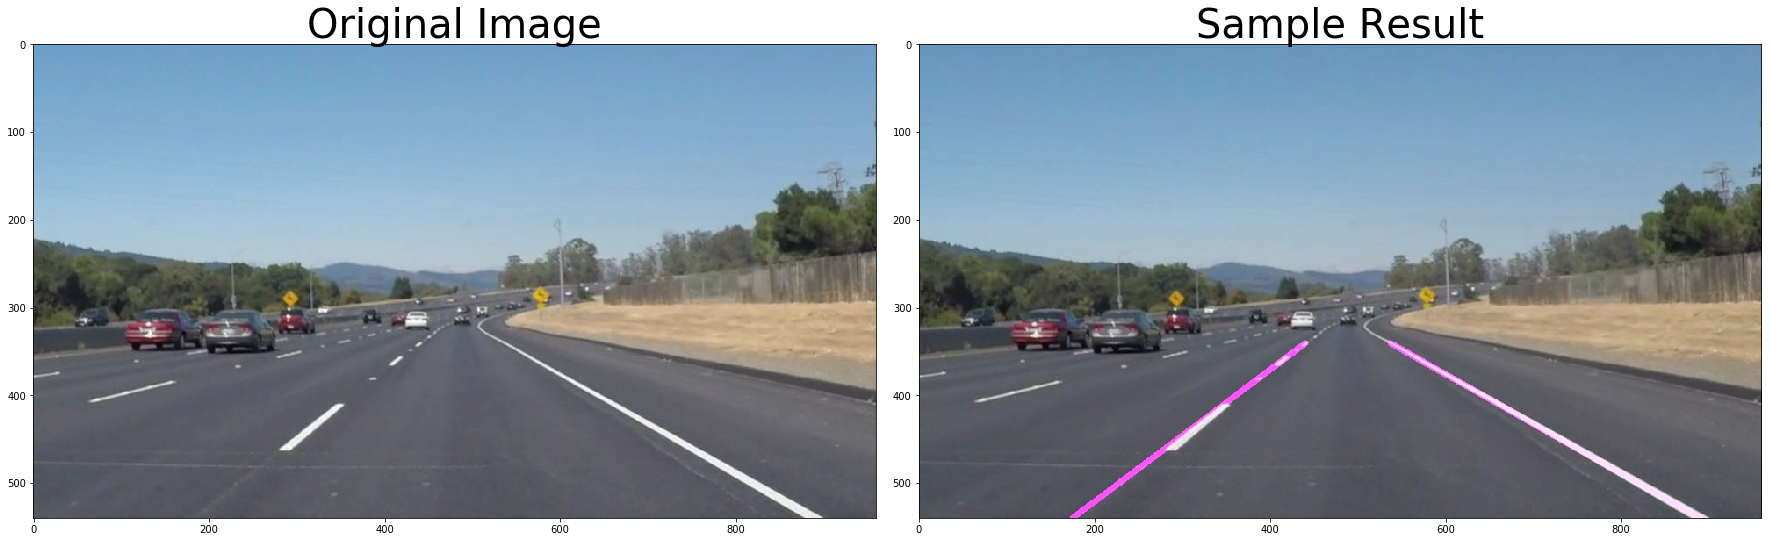

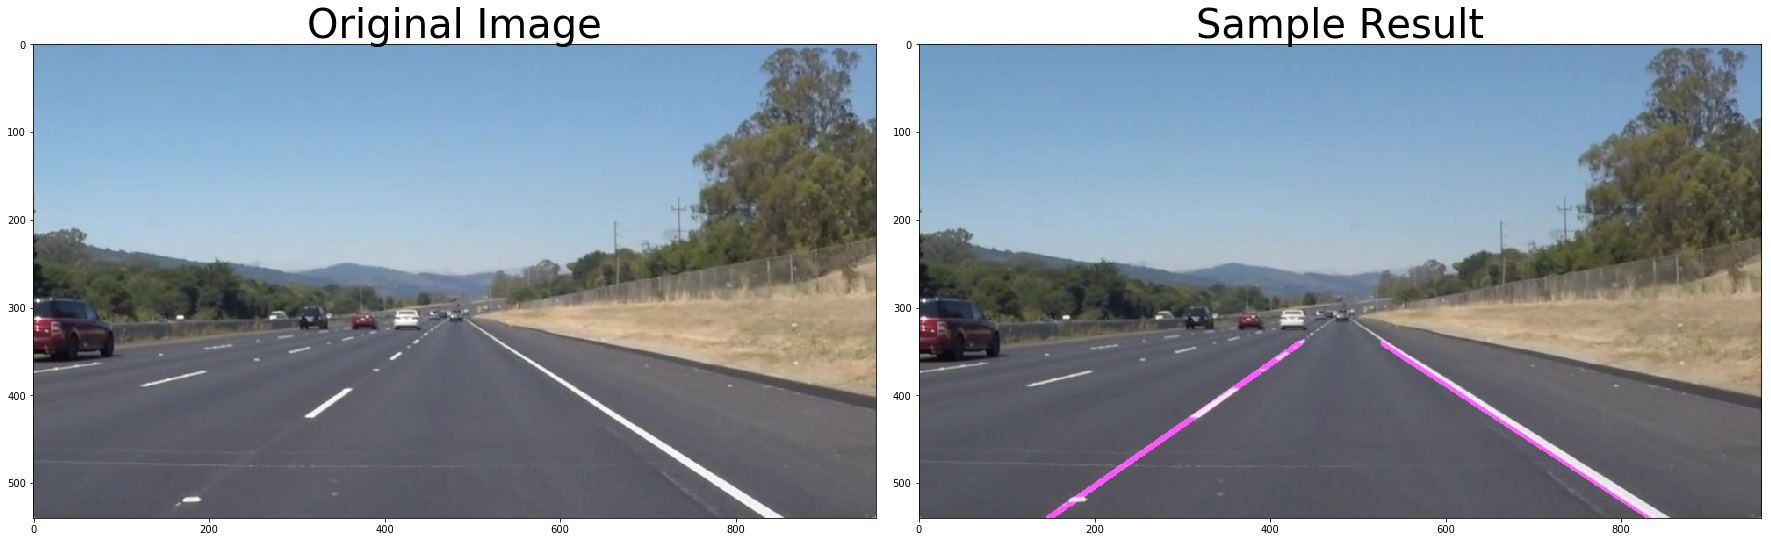

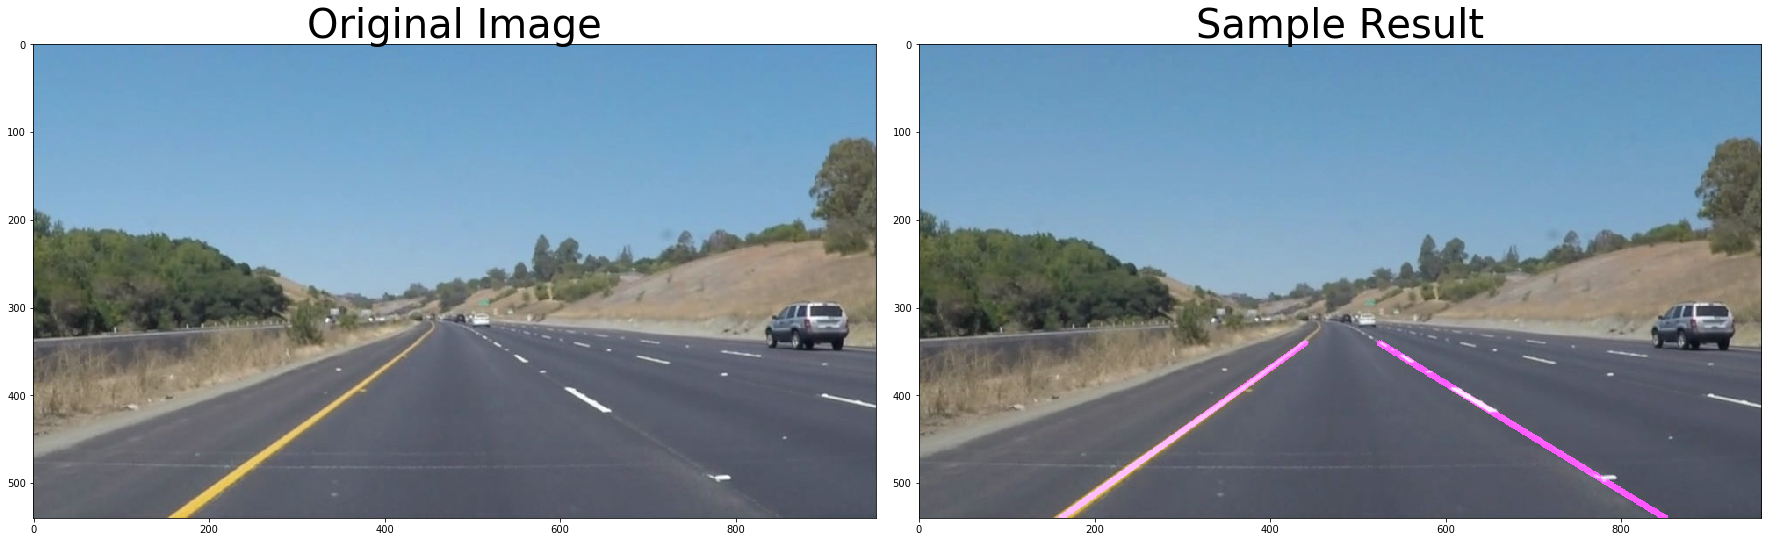

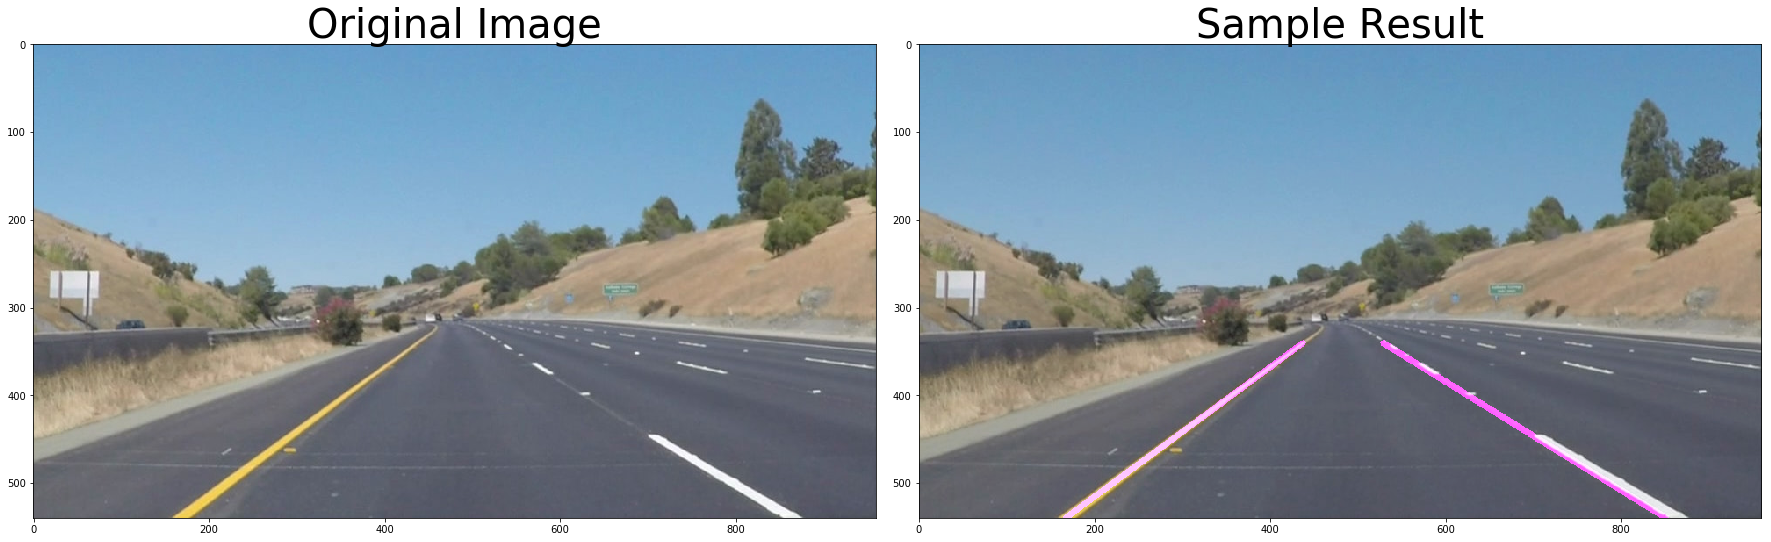

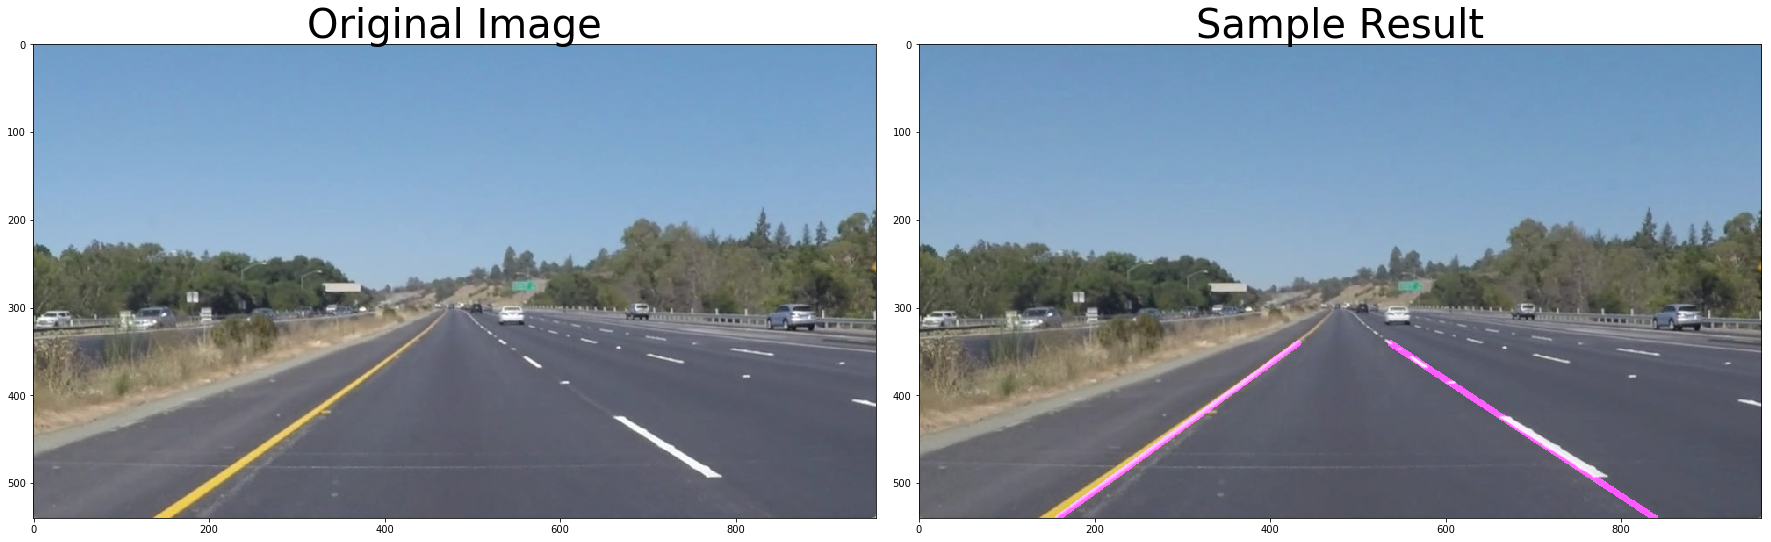

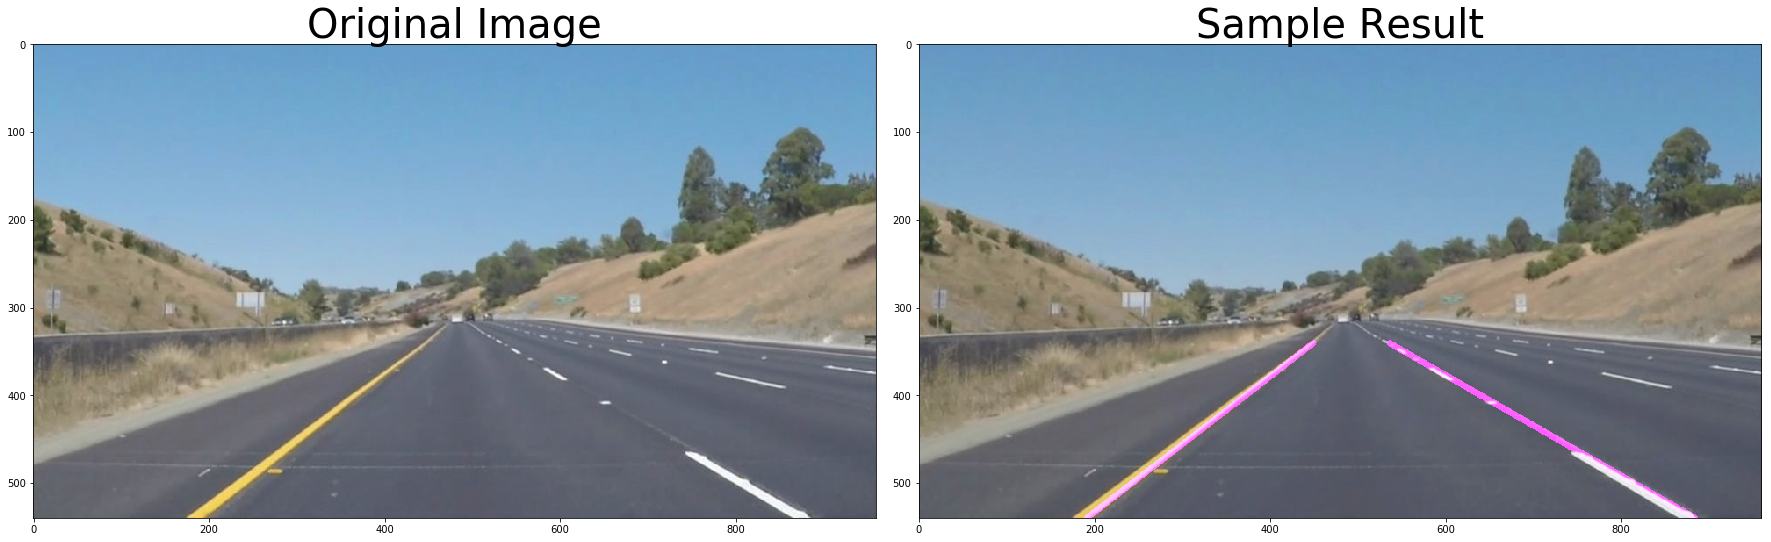

In [77]:
find_lanes_on_test("test_images/")

All images look reasonable and now I would like to test on a video stream. I will consider improving results in the later section. 

## Build a Lane Finding Pipeline for video streams

In [8]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Imageio: 'ffmpeg.linux64' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.linux64 (27.2 MB)
Downloading: 8192/28549024 bytes (0.01712128/28549024 bytes (6.0%4128768/28549024 bytes (14.56758400/28549024 bytes (23.79338880/28549024 bytes (32.711976704/28549024 bytes (42.0%14655488/28549024 bytes (51.3%17260544/28549024 bytes (60.5%19857408/28549024 bytes (69.6%22437888/28549024 bytes (78.6%25141248/28549024 bytes (88.1%27672576/28549024 bytes (96.9%28549024/28549024 bytes (100.0%)
  Done
File saved as /root/.imageio/ffmpeg/ffmpeg.linux64.


In [11]:
!pip install imageio

In [14]:
#to fix the ffmpeg problem - refer to https://discussions.udacity.com/t/error-ffmpeg-exe-file/231460
import imageio

In [33]:
def process_image(image):
    #need to change BGR to RGB because of cv2.imread()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    detected_edges = detect_edges(image)
    masked_edges = confine_roi(image, detected_edges)
    hough_lines = connect_edges(masked_edges)
    median_lanes = extrapolate_lines(image, hough_lines)
    xys = get_xys(image.shape, median_lanes)
    connected_lines = connect_lines(image, xys)
    #addWeighted src1, src1 weight, src2, src2 weight, bias
    output_lines = cv2.addWeighted(image, 0.95, connected_lines, 5., 0.)
    
    #change colour BGR to RGB because of cv2
    output_image = cv2.cvtColor(output_lines, cv2.COLOR_BGR2RGB)
    
    return output_image

In [36]:
#define a video stream to process and make it into many clips/images
video_output = 'test_videos_output/solidYellowLeft.mp4'
clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")

#place each clip of a video stream and process through the pipeline
processed_clip = clip1.fl_image(process_image)

#write each frame of output image into a video stream
%time processed_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4



 83%|████████▎ | 567/682 [00:19<00:04, 27.59it/s]


100%|█████████▉| 681/682 [00:23<00:00, 29.26it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 10.3 s, sys: 950 ms, total: 11.2 s
Wall time: 24.3 s


In [37]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

The lane detection on two video streams look OK altough the curve towards the end of lanes could be detected better. This culvulture challenge is to be addressed in an optional challege problem as the next step!

## Challenge problem solving

In [39]:
# challenge_output = 'test_videos_output/challenge.mp4'
# clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,3)
# challenge_clip = clip3.fl_image(process_image)
# %time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
# HTML("""
# <video width="960" height="540" controls>
#   <source src="{0}">
# </video>
# """.format(challenge_output))